In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.constants import c
from astropy.coordinates import Galactic

import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt

import projections
import mycmap

#data from http://tdc-www.harvard.edu/2mrs/

# Configuration

In [2]:
nside = 1024 # set resolution scale (good to use a power of 2)
smoothing_scale = 0.5 # smoothing scale in degrees
zmin = 0.0 # minimum redshift
zmax = 0.2 # maximum redshift
fname = '2MRS_map_all'

print('resolution: {:0.2f} deg'.format(np.degrees(hp.nside2resol(nside))))
print('number of pixels: {:d}'.format(hp.nside2npix(nside)))

resolution: 0.06 deg
number of pixels: 12582912


# Load 2MASS Redshift Survey data

In [4]:
hdu = fits.open('map_data/2MASS_catalogs/catalog/2mrs_1175_done.fits')
cat = hdu[1].data

## Redshift distribution plot

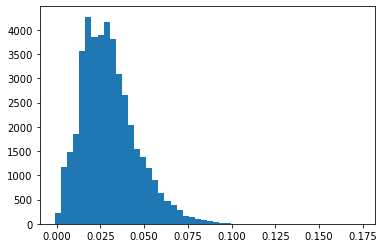

In [5]:
_=plt.hist(cat['V']/c.to('km/s').value,50)

# Create map

In [6]:
pixarea = hp.nside2pixarea(nside,degrees=True)
zvals = cat['V']/c.to('km/s').value
zcond = np.logical_and(zvals>=zmin, zvals<zmax)
catmap = projections.cat2hpx(cat['GLON'][zcond],cat['GLAT'][zcond],nside)/pixarea
catmap_smoothed = hp.smoothing(catmap, fwhm=np.radians(smoothing_scale))

# Generate visualization

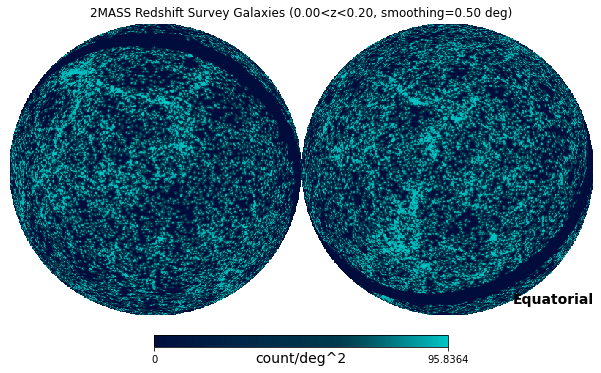

In [7]:
hp.orthview(
    catmap_smoothed,
    coord=["G","C"],
    unit='count/deg^2',
    title="2MASS Redshift Survey Galaxies ({:0.2f}<z<{:0.2f}, smoothing={:0.2f} deg)".format(zmin,zmax,smoothing_scale),
    norm="hist",
    min=0,
    cmap=mycmap.blues)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


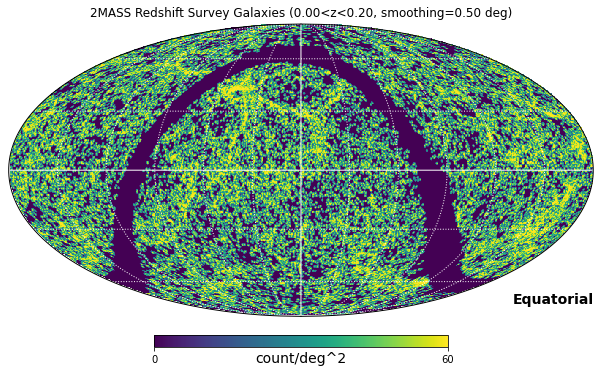

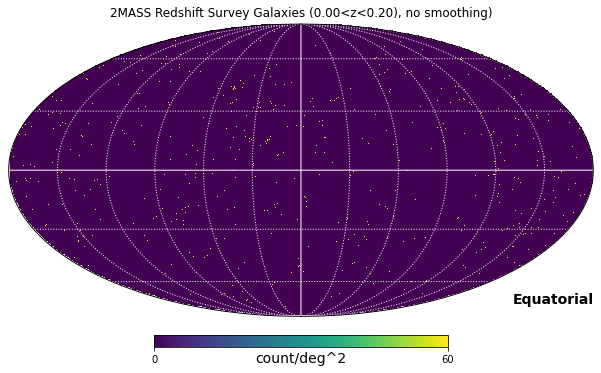

In [16]:
hp.mollview(
    catmap_smoothed,
    coord=["G","C"],
    unit='count/deg^2',
    title="2MASS Redshift Survey Galaxies ({:0.2f}<z<{:0.2f}, smoothing={:0.2f} deg)".format(zmin,zmax,smoothing_scale),
    norm="hist",
    min=0,
    max=60,
    cmap='viridis'
)
hp.graticule(color='white')

hp.mollview(
    catmap,
    coord=["G","C"],
    unit='count/deg^2',
    title="2MASS Redshift Survey Galaxies ({:0.2f}<z<{:0.2f}), no smoothing)".format(zmin,zmax),
    norm="hist",
    min=0,
    max=60,
    cmap='viridis'
)
hp.graticule(color='white')
plt.savefig(fname+'_moll.pdf',format='pdf')

# Test map

Mess around w/ the lat/lon values to build intuition about where these fall in an orthographic projection

In [17]:
lon = -135
lat = -45

0.0 180.0 -180.0 180.0


lat: -45.00 
lon: -135.00


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


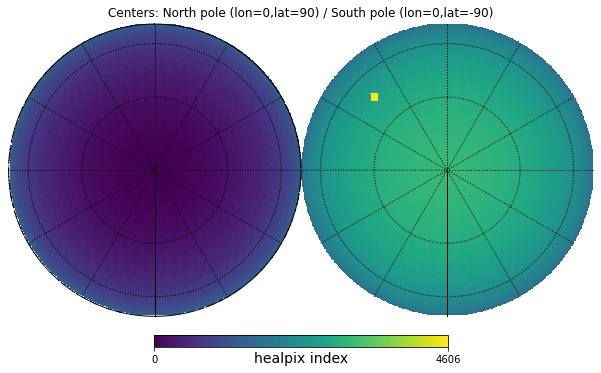

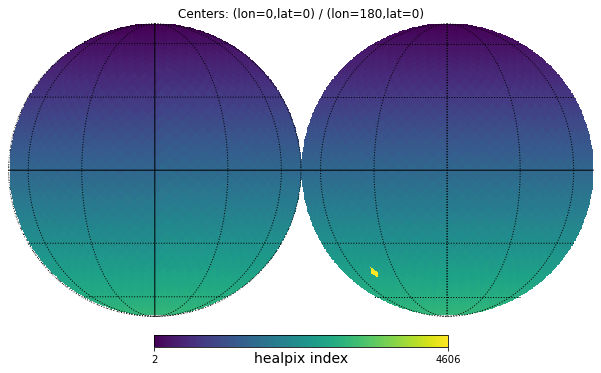

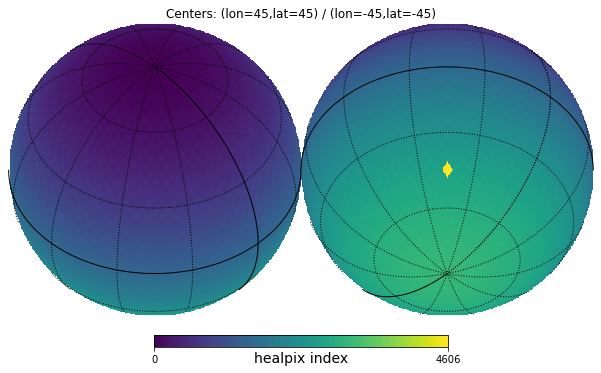

In [18]:
print('lat: {:0.2f} \nlon: {:0.2f}'.format(lat,lon))

ns = 16
test_map = np.arange(hp.nside2npix(ns))

ipix = hp.ang2pix(ns,np.pi/2-np.pi*lat/180,np.pi*lon/180)
test_map[ipix] = 1.5*test_map.max()

hp.orthview(
    test_map,
    title = 'Centers: North pole (lon=0,lat=90) / South pole (lon=0,lat=-90)',
    rot=(0,90),
    unit="healpix index")
hp.graticule()
plt.savefig('ortho_test_1.png',format='png')

hp.orthview(
    test_map,
    title = 'Centers: (lon=0,lat=0) / (lon=180,lat=0)',
    rot=(0,0),
    unit="healpix index")
hp.graticule()
plt.savefig('ortho_test_2.png',format='png')

hp.orthview(
    test_map,
    title = 'Centers: (lon=45,lat=45) / (lon=-45,lat=-45)',
    rot=(45,45),
    unit="healpix index",
    return_projected_map=True)
hp.graticule()
plt.savefig('ortho_test_3.png',format='png')

# Run script to generate tiling-friendly png images

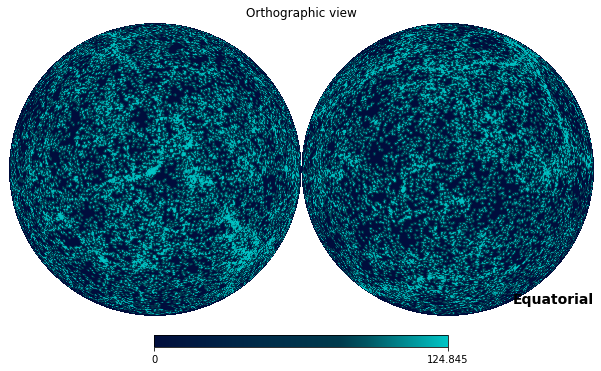

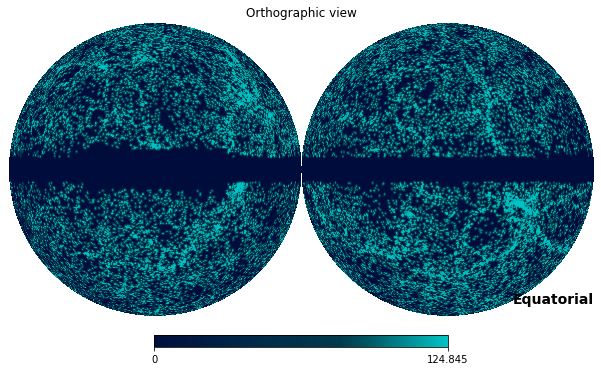

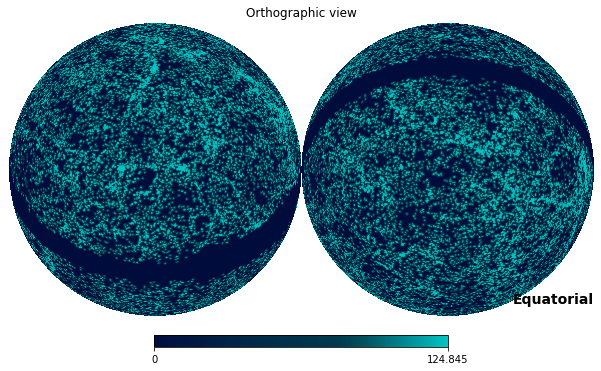

In [38]:
projections.generate_projection_set(catmap_smoothed,
                                    size=4096,
                                    dname='2MRS_galactic_smooth0.5deg_4096',
                                    cmap=mycmap.blues,
                                    norm='hist',
                                    coord=["G"])   

# Experiment with color norm and smoothing

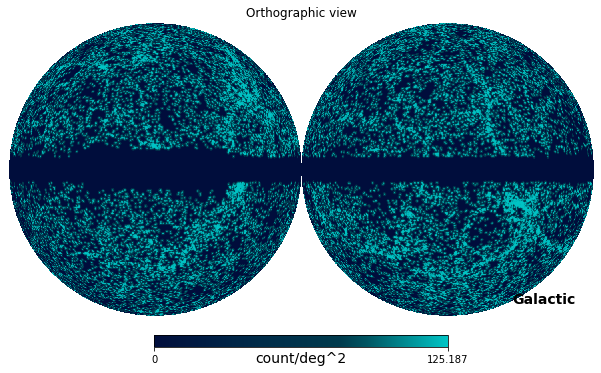

In [21]:
img=hp.orthview(
    catmap_smoothed,
    coord=["G"],
    unit='count/deg^2',
    xsize=2048,
    min=0,
    norm='hist',
    cmap=mycmap.blues,
    return_projected_map=True)

In [22]:
from healpy.projaxes import HistEqNorm

size = img.shape[0]
img[img==-np.inf] = np.nan
vmin=0
vmax=img[~np.isnan(img)].max()

cmap = mycmap.blues
norm = HistEqNorm(vmin=vmin,vmax=vmax)
plt.imsave('pixeltest.png',cmap(norm(img[:,:size])),origin='lower')

masked_array(
  data=[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],
  mask=False,
  fill_value=-1.6375e+30)

In [14]:
import matplotlib.image as mpimg
from scipy import ndimage

img_smooth = ndimage.gaussian_filter(cmap(norm(img[:,:size])), sigma=(10,10,0), order=0)

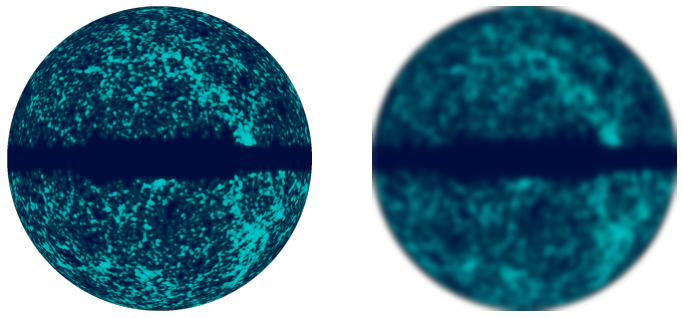

In [15]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(cmap(norm(img[:,:size])))
_=axes[0].axis("off")
axes[1].imshow(img_smooth)
_=axes[1].axis("off")